In [ ]:
#import libraries.
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
#import sounddevice as sd
import tensorflow as tf
from pystoi.stoi import stoi
import h5py
######################
#import libraries.
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
####import sounddevice as sd
import time
print('imported')
# #######################
# from RBM import rbm_layer
Data_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff'
input_name='lilftr_refrmd'
target_name='lilsingle_dataset_log_16'
inputfile=os.path.normpath(os.path.join(Data_path,'lilftr_refrmd'))
targetfile=os.path.normpath(os.path.join(Data_path,'lilsingle_dataset_log_16'))
hh = h5py.File(targetfile+'.hdf5', 'r')
data_out=hh[target_name][0:1000]
len_data=data_out.shape
hh.close()
w=3
print(len_data)
hh = h5py.File(inputfile+'.hdf5', 'r')
data_in=hh[input_name][0:1000]
len_data_in=data_in.shape
hh.close()
print(len_data_in)
# visible = w*len_data[1]
# hidden = 2048
# visible1 = 2048
# hidden1 = 2048
# visible2 = 2048
# hidden2 = 2048
# visible3 = 2048
# hidden3 = len_data[1]
# name1='ftr_scaled.hdf5'
# name2='ftr_scaled'
# layer1 = rbm_layer(visible, hidden, 20, 128, 0.0005, [np.eye(visible)], [np.zeros((1,visible))], 1, len_data[0], name1, name2)
# layer2 = rbm_layer(visible1, hidden1, 20, 128, 0.0005, [np.eye(visible),layer1[0]], [np.zeros((1,visible)),layer1[2]], 2, len_data[0], name1, name2)
# layer3 = rbm_layer(visible2, hidden2, 20, 128, 0.0005, [np.eye(visible),layer1[0],layer2[0]], [np.zeros((1,visible)),layer1[2],layer2[2]], 3, len_data[0], name1, name2)
# layer4 = rbm_layer(visible3, hidden3, 20, 128, 0.0005, [np.eye(visible),layer1[0],layer2[0],layer3[0]], [np.zeros((1,visible)),layer1[2],layer2[2],layer3[2]], 4, len_data[0], name1, name2)
# rbm_layers=[layer1,layer2,layer3,layer4]
# h5f = h5py.File('rbm_params.h5', 'w')
# h5f.create_dataset('rbm_params', data=rbm_layers)
# h5f.close()
# np.savetxt('rbm_layers.txt',rbm_layers)
# l10=np.loadtxt('layers10.txt')
# l11=np.loadtxt('layers11.txt')
# l12=np.loadtxt('layers12.txt')
# l20=np.loadtxt('layers20.txt')
# l21=np.loadtxt('layers21.txt')
# l22=np.loadtxt('layers22.txt')
# l30=np.loadtxt('layers30.txt')
# l31=np.loadtxt('layers31.txt')
# l32=np.loadtxt('layers32.txt')
# l40=np.loadtxt('layers40.txt')
# l41=np.loadtxt('layers41.txt')
# l42=np.loadtxt('layers42.txt')
# layer1=[l10,l11,l12]
# layer2=[l20,l21,l22]
# layer3=[l30,l31,l32]
# layer4=[l40,l41,l42]
# print('saved rbm layers')
#######################
#define reconstruct function to reconstruct sound from framed signal.
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=200, win_length=500, window='hann')
    return recon
#######################
I=0
def da(load_size, data_len):
    global I
    h5f1 = h5py.File(inputfile+'.hdf5','r')
    h5f2 = h5py.File(targetfile+'.hdf5','r')
    indx = np.arange(0, data_len)
    indx = shuffle(indx, random_state=1)
#     indx = np.arange(0, data_len, load_size)
#     indx = shuffle(indx, random_state=1)
    print(indx)
    while True:             #this line is just because keras needs infinite generators
        for I in range(len(indx)): 
            if data_len-I<load_size:
                Data1 = h5f1[inputfile][indx[I]:indx[-1]]
                Data2 = h5f2[targetfile][indx[I]:indx[-1]]
            else:
                Data1 = h5f1[inputfile][indx[I]:indx[I+load_size]]
                Data2 = h5f2[targetfile][indx[I]:indx[I+load_size]]
#                 print(Data1)
#                 print(Data2)
            yield(Data1, Data2)
            
#     print(indx)
#     while True:             #this line is just because keras needs infinite generators
#         for I in indx: 
#             if data_len-I<load_size:
#                 Data1 = h5f1['ftr_refrmd_10h'][I:]
#                 Data2 = h5f2['single_dataset_log_16'][I:]
#             else:
#                 Data1 = h5f1['ftr_refrmd_10h'][I:I+load_size]
#                 Data2 = h5f2['single_dataset_log_16'][I:I+load_size]
#             yield(Data1, Data2)

# file = h5py.File('clean_data.hdf5','r')
# val_y = file['clean_data'][0:]
# file.close()
# file = h5py.File('ftr_refrmd_test.hdf5','r')
# val_x = file['ftr_refrmd_test'][0:]
# file.close()
h = [1024,512]
seed = 7
from tensorflow.keras.layers import Activation
from tensorflow.keras import activations
np.random.seed(seed)
model = Sequential()
act=layers.LeakyReLU(alpha=0.1)
# model.add(Dense(h[0], input_dim = w*len_data[1], kernel_initializer=tf.constant_initializer(layer1[0]), bias_initializer = tf.constant_initializer(layer1[2])))
model.add(Dense(h[0], input_dim = w*len_data[1]))
# model.add(BatchNormalization())
model.add(act)
# model.add(Activation('sigmoid'))
act=layers.LeakyReLU(alpha=0.1)
# model.add(Dense(h[1], kernel_initializer=tf.constant_initializer(layer2[0]), bias_initializer = tf.constant_initializer(layer2[2])))
model.add(Dense(h[1]))
model.add(act)
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# act=keras.layers.LeakyReLU(alpha=0.1)
# model.add(Dense(h[2], kernel_initializer=tf.constant_initializer(layer3[0]), bias_initializer = tf.constant_initializer(layer3[2])))
# model.add(Dense(h[2]))
# model.add(act)
# model.add(BatchNormalization())
# model.add(Activation('relu'))
act=layers.LeakyReLU(alpha=0.1)
# model.add(Dense(len_data[1], kernel_initializer=tf.constant_initializer(layer4[0]), bias_initializer = tf.constant_initializer(layer4[2])))
model.add(Dense(len_data[1]))
# model.add(act)
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# adam_opt = optimizers.adam(lr=0.1, decay=0)
model.compile(loss='mean_squared_error', optimizer='adam')
batch_size=128
steps = len_data[0] // batch_size
# def lr_scheduler(epoch, lr):
#     decay_rate = 0.9
#     if epoch>10:
#         return lr * decay_rate
#     return lr

# lr_callbacks = [
#     keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# ]
# model.fit_generator(da(batch_size, len_data[0]), steps_per_epoch=steps,epochs=50, verbose=1, callbacks = lr_callbacks)
for i in range(995):
    history=model.fit(x=data_in[i:i+5], y=data_out[i:i+5], epochs=100, verbose=1)
# %matplotlib inline
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
    model.save(os.path.normpath(os.path.join(Data_path,'partly_trained.h5')))
    del model
    model = load_model(os.path.normpath(os.path.join(Data_path,'partly_trained.h5')))
# model_json = model.to_json()
# with open("lilmodel.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("lilmodel.h5")
# print("Saved model to disk")

imported
(1000, 257)
(1000, 771)
Epoch 1/100
5/5 [==============================] - 1s 103ms/sample - loss: 43.4544
Epoch 2/100
5/5 [==============================] - 0s 5ms/sample - loss: 19.5200
Epoch 3/100
5/5 [==============================] - 0s 4ms/sample - loss: 10.7646
Epoch 4/100
5/5 [==============================] - 0s 5ms/sample - loss: 6.6237
Epoch 5/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.0253
Epoch 6/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.6677
Epoch 7/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.5902
Epoch 8/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.3648
Epoch 9/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.0727
Epoch 10/100
5/5 [==============================] - 0s 7ms/sample - loss: 1.8735
Epoch 11/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6899
Epoch 12/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.4172

Epoch 2/100
5/5 [==============================] - 0s 4ms/sample - loss: 15.8943
Epoch 3/100
5/5 [==============================] - 0s 5ms/sample - loss: 10.0392
Epoch 4/100
5/5 [==============================] - 0s 5ms/sample - loss: 8.6429
Epoch 5/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.6586
Epoch 6/100
5/5 [==============================] - 0s 7ms/sample - loss: 3.4816
Epoch 7/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.1385
Epoch 8/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.3685
Epoch 9/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.9002
Epoch 10/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.3666
Epoch 11/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.2424
Epoch 12/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1610
Epoch 13/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.1054
Epoch 14/100
5/5 [================

Epoch 4/100
5/5 [==============================] - 0s 4ms/sample - loss: 23.3630
Epoch 5/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.9403
Epoch 6/100
5/5 [==============================] - 0s 4ms/sample - loss: 8.3437
Epoch 7/100
5/5 [==============================] - 0s 4ms/sample - loss: 5.5887
Epoch 8/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.8293
Epoch 9/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.9738
Epoch 10/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.2707
Epoch 11/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.9006
Epoch 12/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.0555
Epoch 13/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.8172
Epoch 14/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.5399
Epoch 15/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.2994
Epoch 16/100
5/5 [===============

Epoch 6/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.3581
Epoch 7/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.3973
Epoch 8/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.8034
Epoch 9/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.7127
Epoch 10/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.1461
Epoch 11/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.0992
Epoch 12/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.6254
Epoch 13/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.1894
Epoch 14/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.0077
Epoch 15/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.9852
Epoch 16/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.8681
Epoch 17/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.7817
Epoch 18/100
5/5 [==============

Epoch 8/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.1130
Epoch 9/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.3421
Epoch 10/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.8173
Epoch 11/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.8088
Epoch 12/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.9078
Epoch 13/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.8006
Epoch 14/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2576
Epoch 15/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.1554
Epoch 16/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.3322
Epoch 17/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.9490
Epoch 18/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.4846
Epoch 19/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.0168
Epoch 20/100
5/5 [============

Epoch 10/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.1016
Epoch 11/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.0802
Epoch 12/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.8020
Epoch 13/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.2407
Epoch 14/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.3139
Epoch 15/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.1509
Epoch 16/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9163
Epoch 17/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.8800
Epoch 18/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.6711
Epoch 19/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.6463
Epoch 20/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6653
Epoch 21/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.6348
Epoch 22/100
5/5 [==========

Epoch 12/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.6638
Epoch 13/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.4565
Epoch 14/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.5222
Epoch 15/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.8984
Epoch 16/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.6948
Epoch 17/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.5713
Epoch 18/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.4636
Epoch 19/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1844
Epoch 20/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0720
Epoch 21/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9113
Epoch 22/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.9857
Epoch 23/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.7242
Epoch 24/100
5/5 [==========

5/5 [==============================] - 0s 4ms/sample - loss: 3.9837
Epoch 14/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.7842
Epoch 15/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.3598
Epoch 16/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.3732
Epoch 17/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.4274
Epoch 18/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.9881
Epoch 19/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.2830
Epoch 20/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.0980
Epoch 21/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.6554
Epoch 22/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.4208
Epoch 23/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1455
Epoch 24/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0247
Epoch 25/100
5/5 [=======================

Epoch 15/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.6796
Epoch 16/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.9844
Epoch 17/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.5878
Epoch 18/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.2261
Epoch 19/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.7812
Epoch 20/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.7083
Epoch 21/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.6191
Epoch 22/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.4723
Epoch 23/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2719
Epoch 24/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.0865
Epoch 25/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.0040
Epoch 26/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9464
Epoch 27/100
5/5 [==========

5/5 [==============================] - 0s 4ms/sample - loss: 6.2335
Epoch 17/100
5/5 [==============================] - 0s 4ms/sample - loss: 5.3558
Epoch 18/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.2257
Epoch 19/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.5893
Epoch 20/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.6454
Epoch 21/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.9975
Epoch 22/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.4308
Epoch 23/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.3372
Epoch 24/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.7016
Epoch 25/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.9375
Epoch 26/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.7443
Epoch 27/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.7912
Epoch 28/100
5/5 [=======================

Epoch 18/100
5/5 [==============================] - 0s 6ms/sample - loss: 4.7009
Epoch 19/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.9796
Epoch 20/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.3388
Epoch 21/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.1764
Epoch 22/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.3044
Epoch 23/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.1893
Epoch 24/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.0397
Epoch 25/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.7709
Epoch 26/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.7789
Epoch 27/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.5925
Epoch 28/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.2657
Epoch 29/100
5/5 [==============================] - 0s 7ms/sample - loss: 1.1506
Epoch 30/100
5/5 [==========

5/5 [==============================] - 0s 5ms/sample - loss: 5.7044
Epoch 20/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.7975
Epoch 21/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.4810
Epoch 22/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.7661
Epoch 23/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.9675
Epoch 24/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.6029
Epoch 25/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.2601
Epoch 26/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.2085
Epoch 27/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.9690
Epoch 28/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.4398
Epoch 29/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.4503
Epoch 30/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.4567
Epoch 31/100
5/5 [=======================

5/5 [==============================] - 0s 4ms/sample - loss: 7.9849
Epoch 21/100
5/5 [==============================] - 0s 4ms/sample - loss: 10.3844
Epoch 22/100
5/5 [==============================] - 0s 4ms/sample - loss: 8.2888
Epoch 23/100
5/5 [==============================] - 0s 5ms/sample - loss: 6.5255
Epoch 24/100
5/5 [==============================] - 0s 5ms/sample - loss: 6.2430
Epoch 25/100
5/5 [==============================] - 0s 5ms/sample - loss: 5.3885
Epoch 26/100
5/5 [==============================] - 0s 5ms/sample - loss: 5.0598
Epoch 27/100
5/5 [==============================] - 0s 6ms/sample - loss: 4.2554
Epoch 28/100
5/5 [==============================] - 0s 5ms/sample - loss: 4.0594
Epoch 29/100
5/5 [==============================] - 0s 8ms/sample - loss: 3.4900
Epoch 30/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.2667
Epoch 31/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.9723
Epoch 32/100
5/5 [======================

Epoch 22/100
5/5 [==============================] - 0s 5ms/sample - loss: 13.3724
Epoch 23/100
5/5 [==============================] - 0s 5ms/sample - loss: 12.0361
Epoch 24/100
5/5 [==============================] - 0s 4ms/sample - loss: 10.5645
Epoch 25/100
5/5 [==============================] - 0s 4ms/sample - loss: 8.1989
Epoch 26/100
5/5 [==============================] - 0s 5ms/sample - loss: 7.3542
Epoch 27/100
5/5 [==============================] - 0s 4ms/sample - loss: 6.7401
Epoch 28/100
5/5 [==============================] - 0s 4ms/sample - loss: 6.6257
Epoch 29/100
5/5 [==============================] - 0s 4ms/sample - loss: 6.0955
Epoch 30/100
5/5 [==============================] - 0s 4ms/sample - loss: 5.4537
Epoch 31/100
5/5 [==============================] - 0s 7ms/sample - loss: 4.6014
Epoch 32/100
5/5 [==============================] - 0s 6ms/sample - loss: 3.6421
Epoch 33/100
5/5 [==============================] - 0s 6ms/sample - loss: 3.5412
Epoch 34/100
5/5 [=======

Epoch 23/100
5/5 [==============================] - 0s 5ms/sample - loss: 5.7144
Epoch 24/100
5/5 [==============================] - 0s 6ms/sample - loss: 5.8906
Epoch 25/100
5/5 [==============================] - 0s 6ms/sample - loss: 4.3499
Epoch 26/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.4139
Epoch 27/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.4354
Epoch 28/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.8326
Epoch 29/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.9713
Epoch 30/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.9497
Epoch 31/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.8405
Epoch 32/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.2113
Epoch 33/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.0981
Epoch 34/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6357
Epoch 35/100
5/5 [==========

Epoch 24/100
5/5 [==============================] - 0s 6ms/sample - loss: 7.8840
Epoch 25/100
5/5 [==============================] - 0s 5ms/sample - loss: 6.8202
Epoch 26/100
5/5 [==============================] - 0s 5ms/sample - loss: 5.7429
Epoch 27/100
5/5 [==============================] - 0s 4ms/sample - loss: 5.8951
Epoch 28/100
5/5 [==============================] - 0s 4ms/sample - loss: 5.1492
Epoch 29/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.8610
Epoch 30/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.9221
Epoch 31/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.3251
Epoch 32/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.4508
Epoch 33/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.4735
Epoch 34/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.8087
Epoch 35/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.6673
Epoch 36/100
5/5 [==========

Epoch 25/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.6730
Epoch 26/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.1756
Epoch 27/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.5935
Epoch 28/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.4628
Epoch 29/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.1374
Epoch 30/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.0462
Epoch 31/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.7617
Epoch 32/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.9118
Epoch 33/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.5460
Epoch 34/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.3970
Epoch 35/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1966
Epoch 36/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.0804
Epoch 37/100
5/5 [==========

Epoch 26/100
5/5 [==============================] - 0s 5ms/sample - loss: 6.0757
Epoch 27/100
5/5 [==============================] - 0s 4ms/sample - loss: 5.0992
Epoch 28/100
5/5 [==============================] - 0s 4ms/sample - loss: 5.7762
Epoch 29/100
5/5 [==============================] - 0s 4ms/sample - loss: 5.1556
Epoch 30/100
5/5 [==============================] - 0s 6ms/sample - loss: 4.1972
Epoch 31/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.3004
Epoch 32/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.3883
Epoch 33/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.2837
Epoch 34/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.1889
Epoch 35/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.9088
Epoch 36/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.2712
Epoch 37/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.0311
Epoch 38/100
5/5 [==========

Epoch 27/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.4641
Epoch 28/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.7854
Epoch 29/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.5076
Epoch 30/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.8372
Epoch 31/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.4829
Epoch 32/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.5972
Epoch 33/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.4639
Epoch 34/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.2257
Epoch 35/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.9154
Epoch 36/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.6949
Epoch 37/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.5448
Epoch 38/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.3878
Epoch 39/100
5/5 [==========

Epoch 28/100
5/5 [==============================] - 0s 4ms/sample - loss: 3.8220
Epoch 29/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.0156
Epoch 30/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.3875
Epoch 31/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.4045
Epoch 32/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.6293
Epoch 33/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.5754
Epoch 34/100
5/5 [==============================] - 0s 7ms/sample - loss: 2.3341
Epoch 35/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.9625
Epoch 36/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.9174
Epoch 37/100
5/5 [==============================] - 0s 7ms/sample - loss: 1.6462
Epoch 38/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6471
Epoch 39/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.4325
Epoch 40/100
5/5 [==========

Epoch 29/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.0055
Epoch 30/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.5435
Epoch 31/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.3703
Epoch 32/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.3773
Epoch 33/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.0119
Epoch 34/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6152
Epoch 35/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.4643
Epoch 36/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.5171
Epoch 37/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.3106
Epoch 38/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1490
Epoch 39/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.0933
Epoch 40/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0468
Epoch 41/100
5/5 [==========

Epoch 30/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.9429
Epoch 31/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.9593
Epoch 32/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.7591
Epoch 33/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.4445
Epoch 34/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.2829
Epoch 35/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.0015
Epoch 36/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.7133
Epoch 37/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6002
Epoch 38/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.5412
Epoch 39/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.4789
Epoch 40/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2553
Epoch 41/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.1294
Epoch 42/100
5/5 [==========

Epoch 31/100
5/5 [==============================] - 0s 4ms/sample - loss: 4.3972
Epoch 32/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.9217
Epoch 33/100
5/5 [==============================] - 0s 5ms/sample - loss: 3.1586
Epoch 34/100
5/5 [==============================] - 0s 8ms/sample - loss: 3.0452
Epoch 35/100
5/5 [==============================] - 0s 8ms/sample - loss: 2.7672
Epoch 36/100
5/5 [==============================] - 0s 7ms/sample - loss: 2.5702
Epoch 37/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.3205
Epoch 38/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.0566
Epoch 39/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.8488
Epoch 40/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.6147
Epoch 41/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.5970
Epoch 42/100
5/5 [==============================] - 0s 8ms/sample - loss: 1.4073
Epoch 43/100
5/5 [==========

Epoch 32/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.7011
Epoch 33/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.5622
Epoch 34/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.4256
Epoch 35/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.4025
Epoch 36/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.2214
Epoch 37/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.1124
Epoch 38/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.9771
Epoch 39/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.9128
Epoch 40/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.8524
Epoch 41/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.7603
Epoch 42/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.6838
Epoch 43/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6265
Epoch 44/100
5/5 [==========

5/5 [==============================] - 0s 4ms/sample - loss: 1.4313
Epoch 34/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.6234
Epoch 35/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.3700
Epoch 36/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.3027
Epoch 37/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.1943
Epoch 38/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.9879
Epoch 39/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.9355
Epoch 40/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.8441
Epoch 41/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.7830
Epoch 42/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.7362
Epoch 43/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6591
Epoch 44/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.6249
Epoch 45/100
5/5 [=======================

5/5 [==============================] - 0s 5ms/sample - loss: 1.5883
Epoch 35/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6020
Epoch 36/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2893
Epoch 37/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0679
Epoch 38/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0234
Epoch 39/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9908
Epoch 40/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9632
Epoch 41/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.8738
Epoch 42/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7398
Epoch 43/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6717
Epoch 44/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.6209
Epoch 45/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.5870
Epoch 46/100
5/5 [=======================

5/5 [==============================] - 0s 5ms/sample - loss: 2.1496
Epoch 36/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.8170
Epoch 37/100
5/5 [==============================] - 0s 6ms/sample - loss: 2.0229
Epoch 38/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6660
Epoch 39/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.5581
Epoch 40/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2425
Epoch 41/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.1036
Epoch 42/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1250
Epoch 43/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0383
Epoch 44/100
5/5 [==============================] - 0s 7ms/sample - loss: 1.0076
Epoch 45/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.7672
Epoch 46/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7167
Epoch 47/100
5/5 [=======================

5/5 [==============================] - 0s 6ms/sample - loss: 2.7311
Epoch 37/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.6411
Epoch 38/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.5749
Epoch 39/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.3698
Epoch 40/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.5948
Epoch 41/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.6962
Epoch 42/100
5/5 [==============================] - 0s 7ms/sample - loss: 1.7405
Epoch 43/100
5/5 [==============================] - 0s 8ms/sample - loss: 1.5788
Epoch 44/100
5/5 [==============================] - 0s 8ms/sample - loss: 1.4421
Epoch 45/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0920
Epoch 46/100
5/5 [==============================] - 0s 10ms/sample - loss: 1.0570
Epoch 47/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.9914
Epoch 48/100
5/5 [======================

Epoch 37/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.3456
Epoch 38/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.0635
Epoch 39/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.7363
Epoch 40/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.7015
Epoch 41/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6176
Epoch 42/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.4727
Epoch 43/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2306
Epoch 44/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2122
Epoch 45/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.0253
Epoch 46/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9998
Epoch 47/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.9028
Epoch 48/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.8454
Epoch 49/100
5/5 [==========

Epoch 38/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.9508
Epoch 39/100
5/5 [==============================] - 0s 4ms/sample - loss: 2.4628
Epoch 40/100
5/5 [==============================] - 0s 5ms/sample - loss: 2.1118
Epoch 41/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.9272
Epoch 42/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.7662
Epoch 43/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6742
Epoch 44/100
5/5 [==============================] - 0s 4ms/sample - loss: 1.5941
Epoch 45/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.3669
Epoch 46/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.2705
Epoch 47/100
5/5 [==============================] - 0s 8ms/sample - loss: 1.1065
Epoch 48/100
5/5 [==============================] - 0s 7ms/sample - loss: 1.0013
Epoch 49/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.9682
Epoch 50/100
5/5 [==========

Epoch 39/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.8167
Epoch 40/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6018
Epoch 41/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.3519
Epoch 42/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2267
Epoch 43/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2383
Epoch 44/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1778
Epoch 45/100
5/5 [==============================] - 0s 6ms/sample - loss: 1.0356
Epoch 46/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.8910
Epoch 47/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7780
Epoch 48/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7309
Epoch 49/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7132
Epoch 50/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7210
Epoch 51/100
5/5 [==========

Epoch 40/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.8817
Epoch 41/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.8195
Epoch 42/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.7444
Epoch 43/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.6858
Epoch 44/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6554
Epoch 45/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.5892
Epoch 46/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.5150
Epoch 47/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.4790
Epoch 48/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.4489
Epoch 49/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.4437
Epoch 50/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.4150
Epoch 51/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.3841
Epoch 52/100
5/5 [==========

Epoch 41/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.9137
Epoch 42/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.6469
Epoch 43/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.5963
Epoch 44/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.4737
Epoch 45/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.3006
Epoch 46/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2241
Epoch 47/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1222
Epoch 48/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0861
Epoch 49/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9536
Epoch 50/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.8641
Epoch 51/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.8247
Epoch 52/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.7820
Epoch 53/100
5/5 [==========

Epoch 42/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.7197
Epoch 43/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.6466
Epoch 44/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.5773
Epoch 45/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.5731
Epoch 46/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.5537
Epoch 47/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.4939
Epoch 48/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.4609
Epoch 49/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.4326
Epoch 50/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.3883
Epoch 51/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.3554
Epoch 52/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.3459
Epoch 53/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.3277
Epoch 54/100
5/5 [==========

Epoch 43/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.2068
Epoch 44/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1912
Epoch 45/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0836
Epoch 46/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9358
Epoch 47/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.8500
Epoch 48/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.7843
Epoch 49/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7672
Epoch 50/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7045
Epoch 51/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6500
Epoch 52/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5897
Epoch 53/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5322
Epoch 54/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.4982
Epoch 55/100
5/5 [==========

Epoch 44/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.1885
Epoch 45/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0665
Epoch 46/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0379
Epoch 47/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9698
Epoch 48/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.8555
Epoch 49/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7830
Epoch 50/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.6995
Epoch 51/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.6925
Epoch 52/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6416
Epoch 53/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5643
Epoch 54/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5322
Epoch 55/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.4977
Epoch 56/100
5/5 [==========

Epoch 45/100
5/5 [==============================] - 0s 9ms/sample - loss: 0.7822
Epoch 46/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.6669
Epoch 47/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.6204
Epoch 48/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5821
Epoch 49/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5078
Epoch 50/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.4739
Epoch 51/100
5/5 [==============================] - 0s 4ms/sample - loss: 0.4739
Epoch 52/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.4551
Epoch 53/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.4317
Epoch 54/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.3915
Epoch 55/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.3354
Epoch 56/100
5/5 [==============================] - 0s 9ms/sample - loss: 0.3179
Epoch 57/100
5/5 [==========

Epoch 46/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.6647
Epoch 47/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.7099
Epoch 48/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.6559
Epoch 49/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.5904
Epoch 50/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.4926
Epoch 51/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.4669
Epoch 52/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.4412
Epoch 53/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.4263
Epoch 54/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.3965
Epoch 55/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.3714
Epoch 56/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.3373
Epoch 57/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.3005
Epoch 58/100
5/5 [==========

Epoch 47/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0979
Epoch 48/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9575
Epoch 49/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.8072
Epoch 50/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.7333
Epoch 51/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6968
Epoch 52/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6480
Epoch 53/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6092
Epoch 54/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5865
Epoch 55/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5108
Epoch 56/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.4293
Epoch 57/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.4168
Epoch 58/100
5/5 [==============================] - 0s 9ms/sample - loss: 0.4266
Epoch 59/100
5/5 [==========

Epoch 48/100
5/5 [==============================] - 0s 5ms/sample - loss: 1.0289
Epoch 49/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.9365
Epoch 50/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.8812
Epoch 51/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.8351
Epoch 52/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.8062
Epoch 53/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.6964
Epoch 54/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.6243
Epoch 55/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.5774
Epoch 56/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5682
Epoch 57/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.5439
Epoch 58/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.4911
Epoch 59/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.4387
Epoch 60/100
5/5 [==========

Epoch 49/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6954
Epoch 50/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.6966
Epoch 51/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5821
Epoch 52/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.5024
Epoch 53/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.4846
Epoch 54/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.4549
Epoch 55/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.4135
Epoch 56/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.3865
Epoch 57/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.3715
Epoch 58/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.3567
Epoch 59/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.3478
Epoch 60/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.3335
Epoch 61/100
5/5 [==========

5/5 [==============================] - 0s 6ms/sample - loss: 0.3616
Epoch 51/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.3405
Epoch 52/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.3191
Epoch 53/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.2996
Epoch 54/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.2819
Epoch 55/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.2572
Epoch 56/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.2401
Epoch 57/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.2246
Epoch 58/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.2243
Epoch 59/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.2148
Epoch 60/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.2011
Epoch 61/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.1861
Epoch 62/100
5/5 [=======================

Epoch 52/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.2782
Epoch 53/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.2578
Epoch 54/100
5/5 [==============================] - 0s 11ms/sample - loss: 0.2428
Epoch 55/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.2330
Epoch 56/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.2220
Epoch 57/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.2075
Epoch 58/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.1943
Epoch 59/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1843
Epoch 60/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1798
Epoch 61/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1729
Epoch 62/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.1653
Epoch 63/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.1592
Epoch 64/100
5/5 [=========

Epoch 54/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.2137
Epoch 55/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.2046
Epoch 56/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.1856
Epoch 57/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.1754
Epoch 58/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.1688
Epoch 59/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1623
Epoch 60/100
5/5 [==============================] - 0s 6ms/sample - loss: 0.1596
Epoch 61/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1500
Epoch 62/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1395
Epoch 63/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1355
Epoch 64/100
5/5 [==============================] - 0s 5ms/sample - loss: 0.1321
Epoch 65/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1294
Epoch 66/100
5/5 [==========

5/5 [==============================] - 0s 8ms/sample - loss: 0.2193
Epoch 56/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.2084
Epoch 57/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1966
Epoch 58/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1870
Epoch 59/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.1806
Epoch 60/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1687
Epoch 61/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1576
Epoch 62/100
5/5 [==============================] - 0s 9ms/sample - loss: 0.1523
Epoch 63/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.1471
Epoch 64/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.1429
Epoch 65/100
5/5 [==============================] - 0s 7ms/sample - loss: 0.1381
Epoch 66/100
5/5 [==============================] - 0s 8ms/sample - loss: 0.1307
Epoch 67/100
5/5 [=======================

In [3]:
data_in.shape

(5, 257)

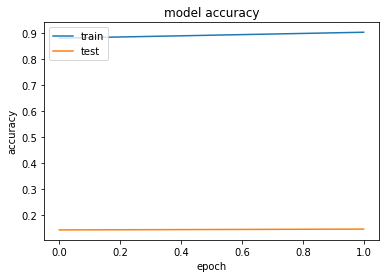

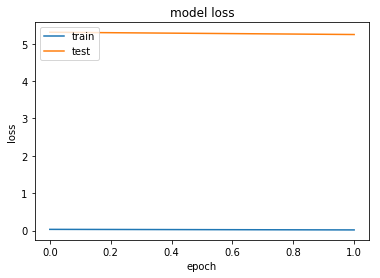

Saved model to disk


In [2]:
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model_json = model.to_json()
with open("model_10h.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_10h.h5")
print("Saved model to disk")

In [6]:
hh = h5py.File('single_dataset_log_16.hdf5', 'r')
d=hh['single_dataset_log_16']
len_data=d.shape
hh.close()
print(len_data)

(7183134, 257)


In [3]:
import h5py 
import tensorflow as tf
hh = h5py.File('ftr_refrmd_10h.hdf5', 'r')
d=hh['ftr_refrmd_10h'][0:500]
data=d
hh.close()
# d=tf.convert_to_tensor(d,tf.float32)
print(type(d[0]))

<class 'numpy.ndarray'>


In [6]:
data[19]

array([-0.08651759,  0.22336993,  0.44741386,  0.92277074,  0.8565611 ,
       -0.21097986,  0.01482241, -0.31860858, -0.69763505, -1.1260797 ,
       -1.3145506 , -1.6120622 , -0.8895558 , -1.2584125 , -0.5357813 ,
       -0.5961562 , -1.5157962 , -1.0339916 , -1.6847466 , -1.2978625 ,
       -1.5814272 , -0.6983488 , -0.72219944, -2.035673  , -0.7506092 ,
       -2.5336158 , -0.52485573, -0.5650042 , -1.1807766 , -0.42296278,
       -0.8960844 , -2.416711  , -1.2472986 , -1.0052608 , -0.85797095,
       -0.62860066, -0.05113654, -0.21714081,  0.0267174 , -0.5353598 ,
       -1.9117582 , -1.4858161 , -1.3420835 , -0.76118916, -0.9266766 ,
       -2.8992896 , -2.095491  , -0.7868872 , -2.2056518 , -0.985487  ,
       -1.4708126 , -2.0216296 , -0.98144644, -1.1434047 , -1.995234  ,
       -1.7717012 , -3.1965823 , -1.4338489 , -1.2426492 , -1.4553313 ,
       -1.7585936 , -1.7883971 , -1.9998507 , -2.7107284 , -2.3896973 ,
       -2.510616  , -2.3158517 , -1.8880926 , -1.8142247 , -1.53

In [9]:
val_y.shape

(13692, 257)

In [37]:
np.savetxt('layers10.txt',layer1[0])
np.savetxt('layers11.txt',layer1[1])
np.savetxt('layers12.txt',layer1[2])
np.savetxt('layers20.txt',layer2[0])
np.savetxt('layers21.txt',layer2[1])
np.savetxt('layers22.txt',layer2[2])
np.savetxt('layers30.txt',layer3[0])
np.savetxt('layers31.txt',layer3[1])
np.savetxt('layers32.txt',layer3[2])
np.savetxt('layers40.txt',layer4[0])
np.savetxt('layers41.txt',layer4[1])
np.savetxt('layers42.txt',layer4[2])


# loadit=np.loadtxt('rbm_layers.txt')
# rbm_layers.dtype

In [43]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
model_weights[m].predict(X_test)

In [2]:
#import libraries.
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
import sounddevice as sd
import time

In [12]:
from RBM import rbm_layer
visible = 7*target.shape[1]
hidden = 2048
visible1 = 2048
hidden1 = 2048
visible2 = 2048
hidden2 = 2048
visible3 = 2048
hidden3 = target.shape[1]
name1='ftr_scaled.hdf5'
name2='ftr_scaled'
layer1 = rbm_layer(visible, hidden, 20, 128, 0.0005, [np.eye(visible)], [np.zeros((1,visible))], 1, target.shape[0], name1, name2)
layer2 = rbm_layer(visible1, hidden1, 20, 128, 0.0005, [np.eye(visible),layer1[0]], [np.zeros((1,visible)),layer1[2]], 2, target.shape[0], name1, name2)
layer3 = rbm_layer(visible2, hidden2, 20, 128, 0.0005, [np.eye(visible),layer1[0],layer2[0]], [np.zeros((1,visible)),layer1[2],layer2[2]], 3, target.shape[0], name1, name2)
layer4 = rbm_layer(visible3, hidden3, 20, 128, 0.0005, [np.eye(visible),layer1[0],layer2[0],layer3[0]], [np.zeros((1,visible)),layer1[2],layer2[2],layer3[2]], 4, target.shape[0], name1, name2)
rbm_layers=[layer1,layer2,layer3,layer4]
h5f = h5py.File('rbm_params.h5', 'w')
h5f.create_dataset('rbm_params', data=rbm_layers)
h5f.close()




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]




In [4]:
#define reconstruct function to reconstruct sound from framed signal.
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=200, win_length=500, window='hann')
    return recon

In [29]:
I=0
def da(batch_size, data_len):
    global I
    while True:             #this line is just because keras needs infinite generators
        for I in range(0,data_len-batch_size,batch_size): 
            h5f = h5py.File('ftr_scaled.hdf5','r')
            Data1 = h5f['ftr_scaled'][I:I+batch_size]
            h5f.close()
            h5f = h5py.File('single_dataset_log_16.hdf5','r')
            Data2 = h5f['single_dataset_log_16'][I:I+batch_size]
            h5f.close()
            yield(Data1, Data2)

In [32]:
#training data, which contains 750000 frames.
# X = refr_ftr
# y = target
h = [2048,2048,2048]
#test frames, which is one frame to get spectrograms from.
#another evaluation is doe lated in the code which computes 
#stoi and sdr.
# X_test = refr_ftr[750000:750000+157]
# Y_test = target[750000:750000+157]
# angle = phase[750000:750000+157]


# sparsity_list = []
# zero_nlist = []
# reconlist = []
# Times = []
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
# create model
model = Sequential()
model.add(Dense(h[0], input_dim = 7*target.shape[1], kernel_initializer=tf.constant_initializer(layer1[0]), bias_initializer = tf.constant_initializer(layer1[2])))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(h[1], kernel_initializer=tf.constant_initializer(layer2[0]), bias_initializer = tf.constant_initializer(layer2[2])))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(h[2], kernel_initializer=tf.constant_initializer(layer3[0]), bias_initializer = tf.constant_initializer(layer3[2])))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(target.shape[1], kernel_initializer=tf.constant_initializer(layer4[0]), bias_initializer = tf.constant_initializer(layer4[2])))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dense(h[0], input_dim = 7*target.shape[1], activation='relu'))
# model.add(Dense(h[1], activation='relu'))
# model.add(Dense(h[2], activation='relu'))
# model.add(Dense(target.shape[1], activation='relu'))
# model.add(Dense(target.shape[1], kernel_initializer='normal'))
# Compile model
adam_opt = optimizers.adam(lr=0.1, decay=0)
model.compile(loss='mean_squared_error', optimizer=adam_opt)
#estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=150, verbose=1)
#kfold = KFold(n_splits=5, random_state=seed)
#results = cross_val_score(estimator, X, y, cv=kfold)
#print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
#estimator.fit(X, y)
batch_size=128
steps = target.shape[0] // batch_size
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    if epoch>10:
        return lr * decay_rate
    return lr

lr_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
]
model.fit_generator(da(batch_size, target.shape[0]), steps_per_epoch=steps,epochs=50, verbose=1, callbacks = lr_callbacks)
#prediction = model.predict(X_test)
# serialize model to JSON
#write and save model.
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# # serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
# #reconstruct the predicted output from network.
# recon = reconstruct(prediction,angle)
# reconlist.append(recon)
# #get weights from model.
# w0 = estimator.model.get_weights()[0]
# w1 = estimator.model.get_weights()[2]
# w2 = estimator.model.get_weights()[4]
# w=[w0,w1,w2]
# #determine sparsity and number of zero neurons.
# nonzeros = np.nonzero(w[0])[0].shape + np.nonzero(w[1])[0].shape + np.nonzero(w[2])[0].shape 
# sparsity = 1 - np.sum(nonzeros)/(refr_ftr.shape[1]*h[0]+h[0]*h[1]+h[1]*target.shape[1])
# sparsity_list.append(sparsity)
# zero_n = get_zerorows(w)
# zero_nlist.append(zero_n)
# #save and write necessary date.
# np.savetxt('recon.txt',reconlist)
# np.savetxt('sparsity_list.txt',sparsity_list)
# np.savetxt('zero_nlist.txt',zero_nlist)


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
7/7 [==============================] - ETA: 2s - loss: 17.01 - 1s 76ms/step - loss: 20.6106
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
7/7 [==============================] - ETA: 0s - loss: 16.11 - 0s 8ms/step - loss: 15.3262
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
7/7 [==============================] - ETA: 0s - loss: 16.09 - 0s 7ms/step - loss: 15.3232
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
7/7 [==============================] - ETA: 0s - loss: 16.09 - 0s 8ms/step - loss: 15.3232
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000000149011612.
7/7 [==============================] - ETA: 0s - loss: 16.09 - 0s 8ms/step - loss: 15.3232
Epoch 6/50

Epoch 00006: LearningRateScheduler setting learning rate to 0.10000

In [193]:
#play output voice which is the output of a network with no regularizer.
sd.play(reconlist[0]*10, 16000)
sf.write(('unseen_None.wav'), reconlist[0]*10, 16000)

In [237]:
np.savetxt('runtimes.txt',Times)
Times

[4193.883036136627,
 4849.418083667755,
 4886.912912130356,
 5412.886659860611,
 6004.0426461696625]

In [241]:
#play output voice which is the output of a network with l2 regularizer.
sd.play(reconlist[1]*10, 16000)
sf.write(('unseen_l2.wav'), reconlist[1]*10, 16000)

In [240]:
#play output voice which is the output of a network with l1 regularizer.
sd.play(reconlist[2] *10, 16000)
sf.write(('unseen_l1.wav'), reconlist[2]*10, 16000)

In [238]:
#play output voice which is the output of a network with group regularizer.
sd.play(reconlist[3] *10, 16000)
sf.write(('unseen_group.wav'), reconlist[3]*10, 16000)

In [239]:
#play output voice which is the output of a network with SGL regularizer.
sd.play(reconlist[4] *10, 16000)
sf.write(('unseen_SGL.wav'), reconlist[4]*10, 16000)

In [5]:
from keras.models import model_from_json
json_file = open('model0.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model0.h5")
print("Loaded model from disk")



Using TensorFlow backend.


Loaded model from disk


In [ ]:
recon_clean = reconstruct(Y_test, angle)
recon_mixed = reconstruct(X_test, angle)

In [59]:
#save data.
sf.write('unseen_mixed.wav', recon_mixed, 16000)
sf.write('unseen_clean.wav', recon_clean, 16000)

In [203]:
sd.play(recon_mixed, 16000)

In [211]:
json_file_none = open('model0.json', 'r')
loaded_model_json_none = json_file_none.read()
json_file_none.close()
loaded_model_none = model_from_json(loaded_model_json_none)
# load weights into new model
loaded_model_none.load_weights("model0.h5")
print("Loaded model from disk")

json_file_l2 = open('model1.json', 'r')
loaded_model_json_l2 = json_file_l2.read()
json_file_l2.close()
loaded_model_l2 = model_from_json(loaded_model_json_l2)
# load weights into new model
loaded_model_l2.load_weights("model1.h5")
print("Loaded model from disk")

json_file_l1 = open('model2.json', 'r')
loaded_model_json_l1 = json_file_l1.read()
json_file_l1.close()
loaded_model_l1 = model_from_json(loaded_model_json_l1)
# load weights into new model
loaded_model_l1.load_weights("model2.h5")
print("Loaded model from disk")

json_file_group = open('model3.json', 'r')
loaded_model_json_group = json_file_group.read()
json_file_group.close()
loaded_model_group = model_from_json(loaded_model_json_group)
# load weights into new model
loaded_model_group.load_weights("model3.h5")
print("Loaded model from disk")

json_file_sgl = open('model4.json', 'r')
loaded_model_json_sgl = json_file_sgl.read()
json_file_sgl.close()
loaded_model_sgl = model_from_json(loaded_model_json_sgl)
# load weights into new model
loaded_model_sgl.load_weights("model4.h5")
print("Loaded model from disk")

Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


In [235]:
model_weights=[loaded_model_none, loaded_model_l2, loaded_model_l1, loaded_model_group, loaded_model_sgl]

In [236]:
#in this part the weights are modified so that if a weight is less than a threshold its zeroed out.
from pystoi.stoi import stoi
model_names=['no reg','l2','l1','group','sgl']
for m in range(len(model_weights)):
    print("results for model "+model_names[m])
    weights = model_weights[m].get_weights()
    sdr_mixed=[]
    sdr=[]
    stoi_mixed=[]
    stoi_eval = []
    zeronr = 0
    for i in range(0,5,2):
        for j in range(len(weights[i])):
            for k in range(len(weights[i][j])):
                if np.abs(weights[i][j][k]) < 1e-5:
                    weights[i][j][k]=0
            temp = np.nonzero(weights[i][j])[0].shape
            if temp == weights[i].shape[1]:
                #if all weights from a neuron are all zero, it means that the neuron is omitted.
                zeronr += 1
    nonzeros = np.nonzero(weights[0])[0].shape + np.nonzero(weights[2])[0].shape + np.nonzero(weights[4])[0].shape 
    sparsity = 1 - np.sum(nonzeros)/(ftr.shape[1]*h[0]+h[0]*h[1]+h[1]*target.shape[1])
    print("sparsity:")
    print(sparsity)
    print("zero neurons:")
    print(zeronr)
    #100 voices are evaluated using SDR and STOI, and its averaged.
    for i in range(800000,800000+100*157,157):
        recon_mixed = reconstruct(X_test,angle)
        recon_clean = reconstruct(Y_test,angle)
        X_test = ftr[i:i+157]
        Y_test = target[i:i+157]
        prediction = model_weights[m].predict(X_test)
        recon = reconstruct(prediction, angle)
        sdr.append(bss_eval_sources(recon_clean, recon, compute_permutation=True)[0][0])
        stoi_eval.append(stoi(recon_clean, recon, 16000, extended=False))
        sdr_mixed.append(bss_eval_sources(recon_clean, recon_mixed, compute_permutation=True)[0][0])
        stoi_mixed.append(stoi(recon_clean, recon_mixed, 16000, extended=False))
    print('prediction stoi: ')
    print(np.mean(np.asarray(stoi_eval)))
    print('mixed stoi: ')
    print(np.mean(np.asarray(stoi_mixed)))
    print('prediction sdr: ')
    print(np.mean(np.asarray(sdr)))
    print('mixed sdr: ')
    print(np.mean(np.asarray(sdr_mixed)))
    print('-------------------------------------------')


results for model no reg
sparsity:
0.00012747813090685511
zero neurons:
0
prediction stoi: 
0.8502018781658421
mixed stoi: 
0.761798788924194
prediction sdr: 
6.369405273040033
mixed sdr: 
3.935131239280896
-------------------------------------------
results for model l2
sparsity:
0.5703635324629655
zero neurons:
0
prediction stoi: 
0.837658878935219
mixed stoi: 
0.761798788924194
prediction sdr: 
6.235915937865186
mixed sdr: 
3.935131239280896
-------------------------------------------
results for model l1
sparsity:
0.051153896874587934
zero neurons:
0
prediction stoi: 
0.7041262565103249
mixed stoi: 
0.761798788924194
prediction sdr: 
1.4882448031481184
mixed sdr: 
3.935131239280896
-------------------------------------------
results for model group
sparsity:
0.6151918765660029
zero neurons:
0
prediction stoi: 
0.7120733166330397
mixed stoi: 
0.761798788924194
prediction sdr: 
1.5681190905828215
mixed sdr: 
3.935131239280896
-------------------------------------------
results for mo

In [97]:
#we can see first layer weights here.
weights_none = loaded_model_none.get_weights()
weights_none[0]

array([[-0.10541639, -0.11203337, -0.2028024 , ..., -0.14105639,
        -0.02640898, -0.26741874],
       [-0.31538433, -0.87092817,  0.15045519, ...,  0.08250466,
         0.21377747,  0.23154591],
       [-0.37044713, -2.1276214 , -0.7767756 , ..., -1.5462991 ,
         0.02828818, -0.40663916],
       ...,
       [ 0.217184  ,  0.3744303 , -0.25406075, ...,  0.30313197,
        -0.10129988, -0.47639948],
       [ 0.37956175,  0.49257466,  0.11651181, ...,  0.40288913,
        -0.05044101,  0.20564316],
       [ 0.30799803,  0.6735903 ,  0.00437123, ...,  0.70599926,
        -0.0634295 ,  0.5263629 ]], dtype=float32)

In [112]:
#we can see first layer weights here.
#before zeroing
weights_l2 = loaded_model_l2.get_weights()
weights_l2[0]

array([[ 2.2748081e-02,  3.6429066e-02,  5.6046619e-33, ...,
        -7.4428597e-34,  2.3167983e-03,  2.2266493e-33],
       [-6.8101035e-03,  4.3759957e-02, -8.9172193e-33, ...,
        -7.2778955e-33, -1.0185386e-01,  2.4851479e-33],
       [ 4.0847931e-02,  5.2484374e-02,  2.1118670e-34, ...,
        -1.0118736e-33, -6.0549568e-02, -5.8096026e-34],
       ...,
       [ 4.0277254e-02, -1.0770088e-02,  3.3916663e-33, ...,
         2.1351273e-33, -2.3281876e-02,  4.1201191e-33],
       [-1.8546725e-02,  8.2013439e-03,  3.4341138e-33, ...,
         2.4918140e-33,  5.2734144e-02,  4.2327105e-33],
       [-7.3502056e-02, -5.4999903e-02,  3.4387225e-33, ...,
         2.3236206e-33,  2.0648794e-02,  4.7854265e-33]], dtype=float32)